![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

#🔎  Zero-Shot Named Entity Recognition in Spark NLP

In this notebook, you will find an example of Zero-Shot NER model (`finner_roberta_zeroshot`) that is the first of its kind and can detect any named entities without using any annotated dataset to train a model.

`ZeroShotNerModel` annotator also allows extracting entities by crafting appropriate prompts to query **any RoBERTa Question Answering model**.


You can check the model card here: [Models Hub](https://nlp.johnsnowlabs.com/2022/09/02/finner_roberta_zeroshot_en.html)

In [0]:
from johnsnowlabs import nlp, finance

🚨 Your Spark-OCR is outdated, installed==4.3.0 but latest version==4.3.1
You can run nlp.install() to update Spark-OCR

#🔎 Answering Questions on Financial Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

📜**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P.

For doing that, several examples (hypotheses) are provided and sent to the Language model, which will use `NLI (Natural Language Inference)` to check if the any information found in the text matches the examples (confirm the hypotheses).

NLI usually works by trying to confirm or reject an hypotheses. The hypotheses are the `prompts` or examples we are going to provide. If any piece of information confirm the constructed hypotheses (answer the examples we are given), then the hypotheses is confirmed and the Zero-shot is triggered.

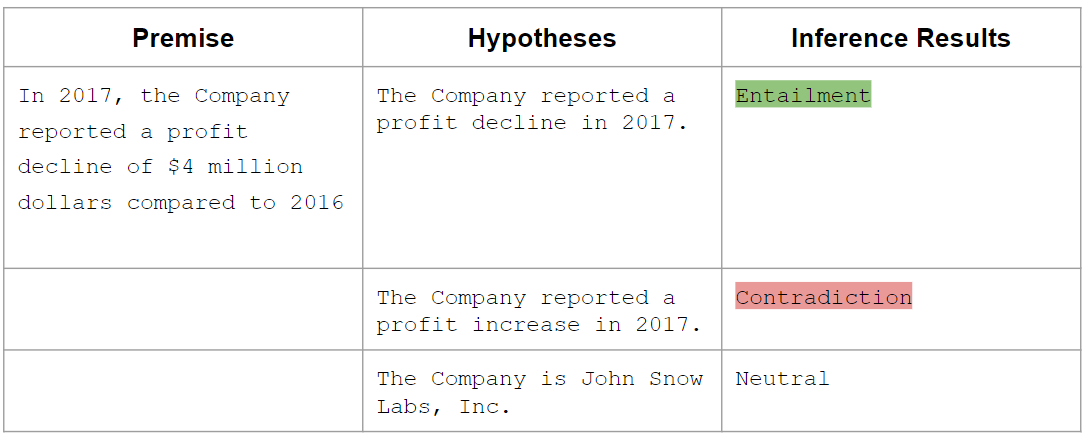

We have built our `Zero-shot` NER and Relation Extraction models on top of Language Models and Question Answering, applying NLI. Since it's a QA model, Zero-shot does not require any training data, just a context and a series of questions.


Let's see it in action.

##🔎 Zero-shot Learning: NER

Named Entity Recognition is the NLP task aimed to tag chunks of information with specific labels.

NER has been historically carried out using rule-based approaches, machine learning and more recently, Deep Learning models, including transformers.

📜If we ignore the traditional rule-based approach, which consisted on having Subject Matter experts (SME) creating rules using regular expressions, vocabularies, ontologies, etc., the common steps for the rest of Machine Learning based NER approaches were:

1. Collect and clean data
2. Having SME annotating many documents;
3. Create features (only if using ML approaches, since Deep Learning does that feature extraction for you in most cases);
4. Train a model on a training dataset;
5. Evaluate on a test test;

📜If it is not accurate, go to step number 1.

This process takes a long time, specially if the nature of the use case is complex and requires many examples for the model to learn.

Thankfully, **Zero-shot** comes to help, since it does not require any training data, drastically speeding up the process. *Zero-shot* models can be:

- It can be a model on its own, with average accuracy;
- It can be used to preannotate the documents and speed up the process of annotations by SME;
- **Finance NLP** includes *Zero-shot* NER, which uses prompts in form of questions, and retrieves the answers to those questions as tagged chunks of information.

*This is an example of Entity labels and some prompts.*

> *While our gross profit margin increased to 81.4% in 2020 from 63.1% in 2019, our revenues declined approximately 27% in 2020...
...
We reported an operating loss of approxiamtely \$8,048,581 million in 2020 as compared to an operating loss of \$7,738,193 in 2019
...*


```
- What is the profit increase?
- What was the decline in revenue?
- What was the operation loss in 2020?
- What was the operation loss in 2019?
```

And this is the result of applying them with our Zero-shot Financial NER model.

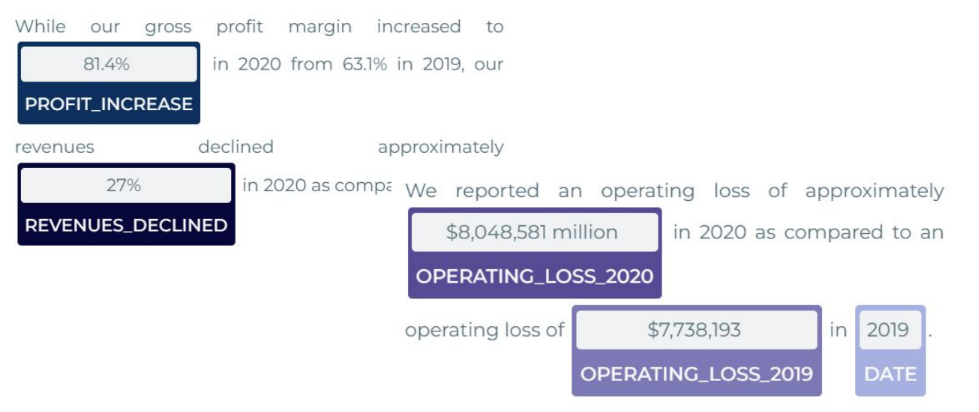

##✔️ How is this achieved?
- We check if the question/prompt (Hypotheses) returns `entailment` for any token in the premise (context/text)
- If several tokens in a row entail the hypotheses, the tokens are merged and returned as one `ner_chunk`

#🚀 Let's start!

In [0]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

textSplitter = finance.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparktokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

zero_shot_ner = finance.ZeroShotNerModel.pretrained("finner_roberta_zeroshot", "en", "finance/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("zero_shot_ner")\
    .setEntityDefinitions(
        {
            "DATE": ['When was the company acquisition?', 'When was the company purchase agreement?'],
            "ORG": ["Which company was acquired?"],
            "PRODUCT": ["Which product?"],
            "PROFIT_INCREASE": ["How much has the gross profit increased?"],
            "REVENUES_DECLINED": ["How much has the revenues declined?"],
            "OPERATING_LOSS_2020": ["Which was the operating loss in 2020"],
            "OPERATING_LOSS_2019": ["Which was the operating loss in 2019"]
        })

nerconverter = nlp.NerConverter()\
    .setInputCols(["sentence", "token", "zero_shot_ner"])\
    .setOutputCol("ner_chunk")

pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  textSplitter,
  sparktokenizer,
  zero_shot_ner,
  nerconverter
    ]
)

finner_roberta_zeroshot download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

In [0]:
from pyspark.sql.types import StructType,StructField, StringType
sample_text = ["In March 2012, as part of a longer-term strategy, the Company acquired Vertro, Inc., which owned and operated the ALOT product portfolio.",
              "In February 2017, the Company entered into an asset purchase agreement with NetSeer, Inc.",
              "While our gross profit margin increased to 81.4% in 2020 from 63.1% in 2019, our revenues declined approximately 27% in 2020 as compared to 2019.",
              "We reported an operating loss of approximately $8,048,581 million in 2020 as compared to an operating loss of $7,738,193 in 2019."]

p_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

res = p_model.transform(spark.createDataFrame(sample_text, StringType()).toDF("text"))

In [0]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result, res.ner_chunk.begin, res.ner_chunk.end, res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['0']").alias("chunk"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)

+------------------+-------------------+
chunk |ner_label |
+------------------+-------------------+
March 2012 |DATE |
Vertro |ORG |
ALOT |PRODUCT |
February 2017 |DATE |
NetSeer |ORG |
81.4% |PROFIT_INCREASE |
27% |REVENUES_DECLINED |
$8,048,581 million|OPERATING_LOSS_2020|
$7,738,193 |OPERATING_LOSS_2019|
2019 |DATE |
+------------------+-------------------+

####✔️ We have just seen how simple it is to obtain the output without having to deal with the hassle of model training.

#### Let's now look at how to enhance the model's predictions in scenarios where there may be incorrectly identified labels or fewer labels overall.

**Let's look at an instance where the text's predictions are incorrect and discuss how to make them better:**

In [0]:
lp = nlp.LightPipeline(p_model)
sample_text = ["In March 2012, as part of a longer-term strategy, the Company acquired Vertro, Inc., which owned and operated the ALOT product portfolio.","According to the latest market data, the current market value of XYZ Corporation's stock is $50 per share.","According to the latest market data, the current market value of ABC Corporation is $10 billion.","The dividend yield of XYZ Company's stock is currently 3%, according to the company's latest shareholder report.","DEF Company has $1 billion in debt, according to the company's latest financial statements.","According to the latest market data, the current market value of XYZ Company's assets is $5 billion."]

# from sparknlp_display import NerVisualizer
for i in range(len(sample_text)):
  print('***'*30,f'Text Number - {i+1}')
  visualiser = nlp.viz.NerVisualizer()
  lp_res_1 = lp.fullAnnotate(sample_text[i])
  vis = visualiser.display(lp_res_1[0], label_col='ner_chunk', document_col='document', return_html=True)
  displayHTML(vis)

****************************************************************************************** Text Number - 1

In March 2012 DATE , as part of a longer-term strategy, the Company acquired Vertro ORG , Inc., which owned and operated the ALOT PRODUCT product portfolio.

****************************************************************************************** Text Number - 2

According to the latest market data, the current market value of XYZ ORG Corporation's stock is $50 per share. PROFIT_INCREASE

****************************************************************************************** Text Number - 3

According to the latest market data, the current market value of ABC Corporation ORG is $10 billion. PROFIT_INCREASE

****************************************************************************************** Text Number - 4

The dividend yield of XYZ ORG Company's stock is currently 3%, PRODUCT according to the company's latest shareholder report.

****************************************************************************************** Text Number - 5

DEF Company has $1 billion in debt, according to the company's latest financial statements. PROFIT_INCREASE

****************************************************************************************** Text Number - 6

According to the latest market data, the current market value of XYZ ORG Company's assets is $5 billion. PROFIT_INCREASE

####✔️ Here, it is clear that many of the model-identified text entities are incorrect.



1.   The label 'PROFIT INCREASE' has been misidentified in the paragraphs 2 and 3, respectively.
2.   For the 4th text `3%` has been wringly identified as `PRODUCT`.
3. The texts in the fifth and sixth texts have also been incorrectly labelled, which has to be fixed.

In [0]:
zero_shot_ner = finance.ZeroShotNerModel.pretrained("finner_roberta_zeroshot", "en", "finance/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("zero_shot_ner")\
    .setEntityDefinitions(
        {
            "DATE": ['When was the company acquisition?', 'When was the company purchase agreement?'],
            "ORG": ["Which company was acquired?"],
            "PRODUCT": ["Which product?"],
            "PROFIT_INCREASE": ["How much gross profit increased?"],
            "REVENUES_DECLINED": ["How much has the revenues declined?"],
            "OPERATING_LOSS_2020": ["Which was the operating loss in 2020"],
            "OPERATING_LOSS_2019": ["Which was the operating loss in 2019"],
            "MARKET_VALUE": ['What is the market value of the company'],
            "DIVIDEND_YIELD": ['What percentage dividend yield is the company offering?'],
            "DEBT": ['How much debt is the company in?']
        })

finner_roberta_zeroshot download started this may take some time.
[ | ][OK!]

####✔️ To make the model predictions better, We could think of adding new labels or rephrasing the texts so that the model can better identify the entities inside the text.

From the sentences, it is clear that there are other valuable entities that can improve the model's ability to predict: `MARKET_VALUE`, `DEBT`, `DIVIDEND_YIELD`.

In [0]:
pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  textSplitter,
  sparktokenizer,
  zero_shot_ner,
  nerconverter
    ]
)

p_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

lp = nlp.LightPipeline(p_model)

sample_text = ["In March 2012, as part of a longer-term strategy, the Company acquired Vertro, Inc., which owned and operated the ALOT product portfolio.","According to the latest market data, the current market value of XYZ Corporation's stock is $50 per share.","According to the latest market data, the current market value of ABC Corporation is $10 billion.","The dividend yield of XYZ Company's stock is currently 3% , according to the company's latest shareholder report.","DEF Company has $1 billion in debt, according to the company's latest financial statements.","According to the latest market data, the current market value of XYZ Company's assets is $5 billion."]

# from sparknlp_display import NerVisualizer
for i in range(len(sample_text)):
  print('***'*30,f'Text Number - {i+1}')
  visualiser = nlp.viz.NerVisualizer()
  lp_res_1 = lp.fullAnnotate(sample_text[i])
  vis = visualiser.display(lp_res_1[0], label_col='ner_chunk', document_col='document', return_html=True)
  displayHTML(vis)

****************************************************************************************** Text Number - 1

In March 2012 DATE , as part of a longer-term strategy, the Company acquired Vertro ORG , Inc., which owned and operated the ALOT PRODUCT product portfolio.

****************************************************************************************** Text Number - 2

According to the latest market data, the current market value of XYZ ORG Corporation's stock is $50 per share MARKET_VALUE .

****************************************************************************************** Text Number - 3

According to the latest market data, the current market value of ABC Corporation ORG is $10 billion MARKET_VALUE .

****************************************************************************************** Text Number - 4

The dividend yield of XYZ ORG Company's stock is currently 3% DIVIDEND_YIELD , according to the company's latest shareholder report.

****************************************************************************************** Text Number - 5

DEF Company has $1 billion DEBT in debt, according to the company's latest financial statements.

****************************************************************************************** Text Number - 6

According to the latest market data, the current market value of XYZ ORG Company's assets is $5 billion MARKET_VALUE .